# XGBoost to predict land and structural values

This project is another machine learning implementation on the Los Angeles housing data set. In this version, I use the more advanced but easier to implement algorithm named XGBoost. XGBoost has taken the machine learning world by storm in recent years as it has been rumored to be used in half of all winning entrents for in machine learning competitions on kaggle.com. In this project, I will take a Zillow data from the eratic housing market of Los Angeles to predict the underlying land values and structural (building) values for each house.   

#### Import packages 

In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Normalizer, OrdinalEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer, Binarizer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import skewtest 

import warnings
warnings.filterwarnings("ignore")

# Part 1 - Land Values

I will use XGBoost to model the land prices for each property. To do this I will exclude all features which are related the structural aspects of the property. 

### Data preprocessing using pipelines 

In [2]:
housing = pd.read_csv('C:/Users/erler/OneDrive/Documents/Random Data Sets/zillow/properties_2017.csv') # Import data

#get rid of duplicates (it's possible they are condos but either way it biases tree algs)
z = [x for x in list(housing.columns) if x not in ['parcelid']]
housing = housing.drop_duplicates(keep = 'first', subset=z)
print(housing.columns)

#create a list of all features related strictly to the land
land= ['parcelid', 'propertylandusetypeid','latitude', 'longitude','propertyzoningdesc', 'regionidneighborhood', 
       'censustractandblock','propertycountylandusecode', 'lotsizesquarefeet', 'landtaxvaluedollarcnt', 
       'structuretaxvaluedollarcnt', 'regionidcounty', 'rawcensustractandblock', 'regionidzip']
   
#Search for errors in price and land sqrfeet    

#Get rid of farms and other extreme outliers
housing = housing.drop(housing.loc[housing['finishedsquarefeet12']>10000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['structuretaxvaluedollarcnt']>10000000].index).reset_index(drop=True)

housing = housing.drop(housing.loc[housing['lotsizesquarefeet']>3000000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['landtaxvaluedollarcnt']<2000].index).reset_index(drop=True)

#dropping observations with missing values for the values below because they are critical to the analysis
housing=housing.dropna(subset=['landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet'])
housing= housing.iloc[:100000,:].reset_index(drop=True)

#eliminate features not related to the land
housing = housing[land]

#this is used to remove '*' and other non alpha-numeric or boolean characters in order for XGBoost to function
def remove_non_AN_characters(array):
    array = array.astype('str')
    array = array.str.replace('\W', '')
    le = LabelEncoder()
    array = le.fit_transform(array)
    array = array.astype('float')
    return array

for i in [x for x in list(housing.columns) if housing[x].dtypes=='O']:
    housing[i] = remove_non_AN_characters(housing[i])

#group numeric features which represent categories    
numcats = ['regionidneighborhood','censustractandblock', 'regionidcity', 
           'rawcensustractandblock','regionidcounty', 'regionidzip', 'propertyzoningdesc', 'propertylandusetypeid']

#set up groupings for different features for preprocessing pipelines
housing_bool=[]
housing_cat=[]
numbers=['propertycountylandusecode']
housing_bool = [x for x in list(housing.columns) if housing[x].dtypes!=float and housing[x].nunique() < 2]
housing_cat = [x for x in list(housing.columns) if housing[x].nunique() < 100 and x not in housing_bool and x not in numcats]
numbers = [x for x in list(housing.columns) if x not in housing_bool and x not in housing_cat and x not in numcats]
housing[housing_bool] = housing[housing_bool].replace(regex={r'$': True})
#housing[housing_cat] = housing[housing_cat].replace(regex={r'$': True})

#binary feature pipeline
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = False)),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

#category feature pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = False)),
    ('oe', OrdinalEncoder()),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

#merge pipelines
full_pipeline = ColumnTransformer([
        ("bin", bin_pipeline, housing_bool),
        ("cat", cat_pipeline, housing_cat),
        #("numcats", numcat_pipeline, numcats),
    ], remainder='passthrough')


#execute pipeline
data_prepared = full_pipeline.fit_transform(housing)
data_prepared = pd.DataFrame(data_prepared) #toarray()

#reintroduce feature headers to transformed dataset
try:
    binary = list(full_pipeline.transformers_[0][1].named_steps['ohe'].get_feature_names(housing_bool))
except:
    binary=[]
try:
    cats = list(full_pipeline.transformers_[1][1].named_steps['ohe'].get_feature_names(housing_cat))
except:
    cats=[]
   
[x for x in list(housing.columns) if x not in housing_bool and x not in housing_cat]
data_prepared.columns = binary+cats+[x for x in list(housing.columns) if x not in housing_bool and x not in housing_cat]

#all cols are getting converted to a object dtype so this serves to convert to numeric dtype 
t =[x for x in list(data_prepared) if data_prepared[x].dtypes=='O']
for i in t:
    data_prepared[i] = data_prepared[i].astype('float')
    
#test model data
train_set, test_set = train_test_split(data_prepared, test_size=0.2, random_state=42)


Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

### Cardinality reduction with k-means clustering 

The following code reduces the 1850 unique property zoning description categories to a manageable 60 categories using kmeans clustering. This is accomplished by first aggregate mean values for the lotsize and y value of price for each of the 1850 categories, along with the mode value for the category feature of property land use type id. Using those three attributes of each property zone we group these into 60 categories using the K-means algorithm. This clustering makes use of the y target variable so it must be done with data we possess. The 60 clusters are mapped back to the original property zone for both the training and test data sets. Once complete the high cardinality property zone feature can be removed.  

In [3]:
x1={'lotsizesquarefeet':'mean', 'landtaxvaluedollarcnt':['mean', lambda x:x.count()], 'propertylandusetypeid':[lambda x:x.value_counts().index[:1]]}
df = train_set.groupby(train_set.propertyzoningdesc, as_index=False).agg(x1).round(0)
df.columns = ["_".join(x) for x in df.columns.ravel()]
df=df.sort_values(by='landtaxvaluedollarcnt_<lambda_0>', ascending=False).reset_index(drop=True) #informational
df['cmsum'] = df['landtaxvaluedollarcnt_<lambda_0>'].cumsum(axis=0)/df['landtaxvaluedollarcnt_<lambda_0>'].sum() #informational
pd.set_option('display.max_rows', len(housing.propertyzoningdesc.value_counts())) #informational

#create table mapping original values to cluster assignments
df2=0
df2 = df.drop(['landtaxvaluedollarcnt_<lambda_0>', 'cmsum'], axis=1).set_index('propertyzoningdesc_')
# transform 'propertylandusetypeid_<lambda>' categories to simple numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df2['propertylandusetypeid_<lambda>'])
df2['propertylandusetypeid_<lambda>'] = le.transform(df2['propertylandusetypeid_<lambda>'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=60, random_state=0).fit(df2)
df2['x2']=kmeans.predict(df2)
df2=df2.reset_index()

#merge clusters to train and test sets, then drop original high cardinality variable.
train_set = train_set.merge(df2[['propertyzoningdesc_','x2']], left_on='propertyzoningdesc', right_on='propertyzoningdesc_',
                        how='left').drop(['propertyzoningdesc_','propertyzoningdesc'], axis=1).set_index(train_set.index)

train_set.rename(columns={'x2':'propertyzoningdesc'}, inplace=True)

test_set = test_set.merge(df2[['propertyzoningdesc_','x2']], left_on='propertyzoningdesc', right_on='propertyzoningdesc_',
                        how='left').drop(['propertyzoningdesc_','propertyzoningdesc'], axis=1).set_index(test_set.index)

test_set.rename(columns={'x2':'propertyzoningdesc'}, inplace=True)

### Implement XGBoost 

In [4]:
#training set
training = train_set.drop(['landtaxvaluedollarcnt', 'parcelid'], axis=1) # drop labels for training set
training_labels = train_set['landtaxvaluedollarcnt'].copy()



#test set
testing = test_set.drop(['landtaxvaluedollarcnt', 'parcelid'], axis=1) # drop labels for training set
testing_labels = test_set['landtaxvaluedollarcnt'].copy()    

###################### XGBoost #########################
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
XGBR = XGBRegressor()

parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.02],
              'gamma': [0], #so called `eta` value
              'n_estimators': [500],
              'max_depth': [6],
              'min_child_weight': [4],
              'silent': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
             }


xgb_grid = GridSearchCV(XGBR,
                        parameters,
                        cv = 2,
                        n_jobs = 2,
                        verbose=True)

xgb_grid.fit(training, training_labels)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

modelland = xgb_grid.best_estimator_
test_set['estimatesland'] = pd.DataFrame(modelland.predict(testing).reshape(-1,1)).set_index(test_set.index)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   22.9s finished


0.5487445156531384
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'objective': 'reg:squarederror', 'silent': 0, 'subsample': 0.7}


### Results - Land 

The best model using the steps previously mentioned for using XGBoost to predict land values resulted in a RMSE of 277,746, r2 of .502, and a median absolute error of 87,214 which was a modest improvement over the best linear method. Like the structure values, I ultimately was not able to garner much predictive value using this data set. The land values had a median value of 174,949 and to estimate all values using this median would result in a median absolute error of about $116K, which is not terribly worse than our best prediction value. Overall, this was a difficult data set due the lack of a signal coming from the independent variables for the dependent variable. 

In [6]:
#Metrics
model = modelland

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(model.predict(testing).reshape(-1,1))
print("median abs error: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs error:  87214.3671875
r2:  0.5018070244636252
mean:  0   266083.25
dtype: float32
rmse:  277746.8182987449


### SHAP values

The SHAP bar graph below displays the impact each variable had on the model. 

For more info about SHAP files: https://github.com/slundberg/shap

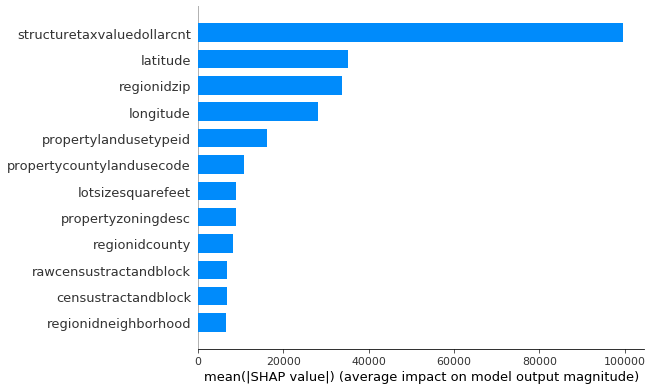

In [7]:
#SHAP
import shap
shap.initjs()

shaps = testing
explainer = shap.TreeExplainer(modelland)
shap_values = explainer.shap_values(shaps)

shap.summary_plot(shap_values, testing, plot_type='bar')

# Part 2 - Structure Values

Part 2 is meant to predict the structural values on the land. Theoretically, two identical homes would have the same structural value and any price difference would be a attributable to the land the home sits on. We'll soon find this not to be the case according to the data. 

In [8]:
housing2 = pd.read_csv('C:/Users/erler/OneDrive/Documents/Random Data Sets/zillow/properties_2017.csv')
#get rid of duplicates (it's possible they are condos but either way it biases tree algs)
z = [x for x in list(housing2.columns) if x not in ['parcelid']]
housing2 = housing2.drop_duplicates(keep = 'first', subset=z)

#drop floats which are primarily Nan
#housing2 = housing2.drop([x for x in list(housing2.columns) if 
 #                       housing2[x].isna().sum()/len(housing2) > .9 and housing2[x].dtypes == float  and housing2[x].dtypes == float and housing2[x].nunique() > 10], axis = 1)

#remove those related to the land
land= ['propertylandusetypeid', 'lotsizesquarefeet', 'regionidcity', 'regionidneighborhood', 'censustractandblock', 
       'longitude', 'latitude', 'regionidcounty','regionidzip', 'rawcensustractandblock', 'propertycountylandusecode',
                        'propertyzoningdesc', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

others = ['calculatedbathnbr', 'assessmentyear', 'taxdelinquencyflag','numberofstories',
 'roomcnt', 'fireplacecnt', 'fips', 'fireplaceflag', 'fullbathcnt', 'calculatedfinishedsquarefeet']

housing2 = housing2.drop(others, axis=1) #remove features identified in 'others list'

housing2=housing2.dropna(subset=['landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet'])

housing2 = housing2.drop(housing2.loc[housing2['lotsizesquarefeet']>3000000].index).reset_index(drop=True)
housing2 = housing2.drop(housing2.loc[housing2['landtaxvaluedollarcnt']<2000].index).reset_index(drop=True)

housing2 = housing2.drop(housing2.loc[housing2['finishedsquarefeet12']>10000].index).reset_index(drop=True)
housing2 = housing2.drop(housing2.loc[housing2['structuretaxvaluedollarcnt']>10000000].index).reset_index(drop=True)

housing2 = housing2.drop(land, axis = 1)

housing2= housing2.iloc[:100000,:].reset_index(drop=True)

housing2_bool = [x for x in list(housing2.columns) if housing2[x].dtypes!=float and housing2[x].nunique() < 2]
numbers = [x for x in list(housing2.columns) if x not in housing2_bool]
housing2[housing2_bool] = housing2[housing2_bool].replace(regex={r'$': True})

bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = False)),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

full_pipeline = ColumnTransformer([
        ("t", bin_pipeline, housing2_bool),
    ], remainder='passthrough')

data_prepared = full_pipeline.fit_transform(housing2)
data_prepared = pd.DataFrame(data_prepared) 

data_prepared.columns = list(full_pipeline.transformers_[0][1].named_steps['ohe'].get_feature_names(housing2_bool))+numbers

#test model data
train_set, test_setstr = train_test_split(data_prepared, test_size=0.2, random_state=42)

#training set
training = train_set.drop(['structuretaxvaluedollarcnt', 'parcelid'], axis=1) # drop labels for training set
training_labels = train_set['structuretaxvaluedollarcnt'].copy()

#test set
testing = test_setstr.drop(['structuretaxvaluedollarcnt', 'parcelid'], axis=1) # drop labels for training set
testing_labels = test_setstr['structuretaxvaluedollarcnt'].copy()

########### XGBoost #########################
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
XGBR = XGBRegressor()

parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.02],
              'gamma': [0], #so called `eta` value
              'n_estimators':[500],
              'max_depth': [5],
              'min_child_weight': [5],
              'silent': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'alpha': [0, .1],
              'eval_metric': ['rmse']    
             }

xgb_grid = GridSearchCV(XGBR,
                        parameters,
                        cv = 2,
                        n_jobs = 6,
                        verbose=True)

xgb_grid.fit(training, training_labels)

modelstructure = xgb_grid.best_estimator_

test_setstr['estimatestructure'] = pd.DataFrame(modelstructure.predict(testing).reshape(-1,1)).set_index(test_setstr.index)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:   32.6s finished


### Results - structure

This XGBoost method resulted in a RMSE of 121,070, and a median absolute variance of 33,339. Both of which are drastically lower than the previously scores. If the estimate had been simply using the median structure value of 126,230, the resulting median absolute error would have been 57,386. 

In [9]:
#Metrics
model = modelstructure

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(model.predict(testing).reshape(-1,1))
print("median abs error: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs error:  33339.31640625
r2:  0.6680054473667973
mean:  0   176986.52
dtype: float32
rmse:  121069.73605224366


### SHAP values

The SHAP bar graph below displays the impact each variable had on the model.

For more info about SHAP files: https://github.com/slundberg/shap

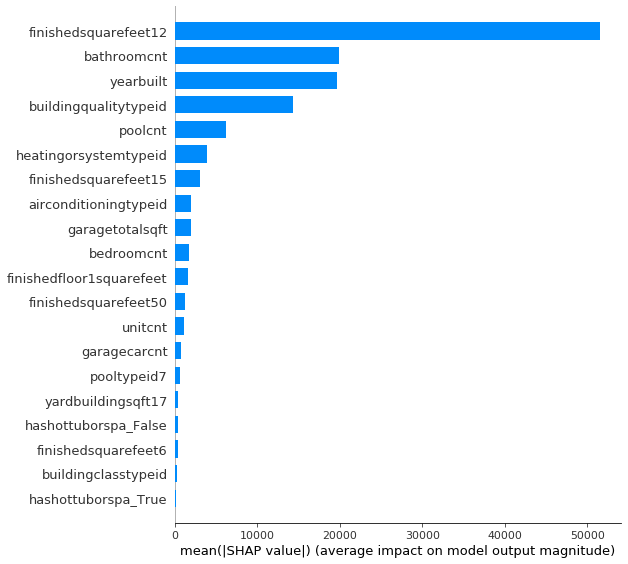

In [10]:
#SHAP
import shap
shap.initjs()

shaps = testing
explainer = shap.TreeExplainer(modelstructure)
shap_values = explainer.shap_values(shaps)

shap.summary_plot(shap_values, testing, plot_type='bar')

# Part 3 - Analysis

Since the models created in this project proved to not have a very useful predictive power, the next section will look for any commonality and trends in variances. One draw back in this exploration is that I have limited information on the properties. For example, if the main reasons for high variability in the data is due to factors like lot shape, proximity to roads, home improvements, home damage, I will not know this because this information is not contained in my original dataset provided by Zillow. Anecdotal evidence from realtors suggests that the ‘Zestimate’ price has difficulty when factoring in hyperlocal features such as proximity water, noisy traffic, unaccounted renovations (especially in older neighborhoods), and undesirable home layouts.

### Merge land and structure data results

In [11]:
test_set = test_set.drop('structuretaxvaluedollarcnt', axis=1)
merged_set = test_set.merge(test_setstr, left_on='parcelid', right_on='parcelid',
                        how='left')

In [12]:
#create variances
pd.set_option('display.max_columns', None)
merged_set['structvar']= merged_set['structuretaxvaluedollarcnt']-merged_set['estimatestructure']
merged_set['structvar %']= merged_set['structvar']/merged_set['structuretaxvaluedollarcnt']
merged_set

merged_set['landvar']= merged_set['landtaxvaluedollarcnt']-merged_set['estimatesland']
merged_set['landvar %']= merged_set['landvar']/merged_set['landtaxvaluedollarcnt']
merged_set

,parcelid,propertylandusetypeid,latitude,longitude,regionidneighborhood,censustractandblock,propertycountylandusecode,lotsizesquarefeet,landtaxvaluedollarcnt,regionidcounty,rawcensustractandblock,regionidzip,propertyzoningdesc,estimatesland,hashottuborspa_False,hashottuborspa_True,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,structuretaxvaluedollarcnt,taxdelinquencyyear,estimatestructure,structvar,structvar %,landvar,landvar %
0,12729745.00,266.00,33920500.00,-118036000.00,nan,60375031051005.00,7.00,82423.00,129400.00,3101.00,60375031.05,96172.00,6.00,109736.04,1.00,0.00,1.00,nan,nan,2.00,2.00,nan,6.00,nan,nan,954.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,1983.00,115600.00,nan,108046.62,7553.38,0.07,19663.96,0.15
1,10762040.00,261.00,34213199.00,-118533149.00,40548.00,60371314002001.00,0.00,13326.00,292891.00,3101.00,60371314.00,96364.00,42.00,257614.27,1.00,0.00,1.00,nan,nan,4.00,5.00,nan,7.00,nan,nan,2605.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,2003.00,257656.00,nan,310355.16,-52699.16,-0.20,35276.73,0.12
2,12248526.00,266.00,33875300.00,-118292000.00,nan,60376031023000.00,7.00,56184.00,52436.00,3101.00,60376031.02,96104.00,39.00,126107.51,1.00,0.00,nan,nan,nan,3.00,2.00,nan,8.00,nan,nan,1264.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,1979.00,155030.00,nan,145089.34,9940.66,0.06,-73671.51,-1.40
3,12958117.00,266.00,34150700.00,-118011000.00,nan,60374310014000.00,7.00,121950.00,10669.00,3101.00,60374310.01,96273.00,37.00,149408.16,1.00,0.00,1.00,nan,nan,2.00,2.00,nan,8.00,nan,nan,1260.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,1979.00,126229.00,nan,134065.97,-7836.97,-0.06,-138739.16,-13.00
4,14419006.00,261.00,33520509.00,-117763376.00,nan,60590626202038.00,81.00,3825.00,1717958.00,1286.00,60590626.20,96969.00,42.00,738316.25,1.00,0.00,nan,nan,nan,4.50,3.00,nan,nan,nan,nan,1802.00,nan,nan,nan,nan,2.00,620.00,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,1940.00,205165.00,nan,195722.59,9442.41,0.05,979641.75,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12096441.00,266.00,34148700.00,-118164000.00,274684.00,60374617002002.00,7.00,51898.00,337516.00,3101.00,60374617.00,96291.00,36.00,190246.27,1.00,0.00,1.00,nan,nan,2.00,2.00,nan,8.00,nan,nan,1310.00,nan,nan,nan,nan,nan,nan,2.00,1.00,nan,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,1972.00,166476.00,nan,134900.52,31575.48,0.19,147269.73,0.44
19996,11085299.00,261.00,34250906.00,-118582544.00,37835.00,60371133222006.00,0.00,5034.00,98179.00,3101.00,60371133.22,96346.00,42.00,244450.00,1.00,0.00,1.00,nan,nan,3.00,5.00,nan,8.00,nan,nan,2171.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,1977.00,259373.00,nan,191225.44,68147.56,0.26,-146271.00,-1.49
19997,14111582.00,261.00,33820349.00,-118059159.00,nan,60591101174007.00,81.00,1853.00,285349.00,1286.00,60591101.17,96185.00,42.00,222823.16,1.00,0.00,13.00,nan,nan,2.50,4.00,nan,nan,nan,nan,1748.00,nan,nan,nan,nan,2.00,462.00,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,1968.00,86014.00,nan,116646.90,-30632.90,-0.36,62525.84,0.22
19998,12507227.00,261.00,33795541.00,-118163015.00,nan,60375734031019.00,0.00,5009.00,269184.00,3101.00,60375734.03,96234.00,28.00,356161.31,1.00,0.00,1.00,nan,nan,3.00,3.00,nan,7.00,nan,nan,2223.00,nan,nan,nan,nan,nan,nan,2.00,nan,nan,n

# Variance Analysis

In this section I am going to dig into what types of observations were the hardest to predict in the this data set. To do this I will split the data into two section, those which had a prediction errors greater than one standard deviation and those less than one standard deviation. From here the data is aggregated using mean values for numeric data and the mode for categorical data (most frequently occurring category).

(One standard deviation is somewhat arbitrary we could look for a more precise inflection point, however, this will suffice for this analysis.) 

## Structures value prediction variances

Below, is a histogram which shows the absolute percentage variance from actual values. Based on this I will seperate the predictions into 3 groups, over estimates, underestimates, and reasonable predictions. Overestimates, are those which are .5 and above, while underestimates are -.5 and below.  

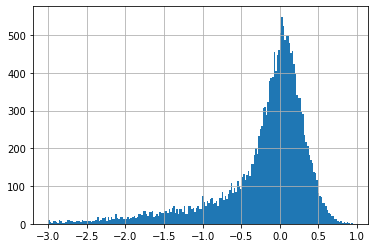

In [13]:
merged_set['structvar %'][merged_set['structvar %']>-3].hist(bins=200)

In [14]:
#seperate variables into categories and continuous
cats = ['propertyzoningdesc', 'buildingclasstypeid', 'heatingorsystemtypeid']
cont = ['lotsizesquarefeet', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt','estimatesland', 'estimatestructure','hashottuborspa_True', 'basementsqft', 
 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'garagetotalsqft', 'poolcnt', 'unitcnt', 'yearbuilt', 'buildingqualitytypeid']

#seperate data set by standard deviation of error
v = 'structvar %'
cutoff=.5
large_variances_underestimates = merged_set.loc[merged_set[v]>=cutoff]
small_variances = merged_set.loc[(merged_set[v]<cutoff) & (merged_set[v]>-cutoff)]
large_variances_overestimates = merged_set.loc[merged_set[v]<=-cutoff]

#make a table
x1 = {i:'mean' for i in cont}
x2 = {i:[lambda x:x.value_counts().index[:1][0]] for i in cats} #mode categorical value
table_continuous_struct_over = pd.concat([large_variances_overestimates.agg(x1).round(2), small_variances.agg(x1).round(2)], axis=1) #apply agg functions
table_categories_struct_over = pd.concat([large_variances_overestimates.agg(x2).round(2), small_variances.agg(x2).round(2)], axis=0).transpose() #apply agg functions

table_continuous_struct_under = pd.concat([large_variances_underestimates.agg(x1).round(2), small_variances.agg(x1).round(2)], axis=1) #apply agg functions
table_categories_struct_under = pd.concat([large_variances_underestimates.agg(x2).round(2), small_variances.agg(x2).round(2)], axis=0).transpose() #apply agg functions

names = {0:'large_variances',1:'small_variances'}

#overestimates
table_continuous_struct_over.rename(columns = names, inplace=True)
table_categories_struct_over.columns = ['large_variances', 'small_variances']
table_continuous_struct_over['variance'] = table_continuous_struct_over['large_variances']-table_continuous_struct_over['small_variances']
table_continuous_struct_over['variance %'] = table_continuous_struct_over['variance']/table_continuous_struct_over['small_variances']
table_categories_struct_over['variance'] = table_categories_struct_over['large_variances']-table_categories_struct_over['small_variances']

#underestimates
table_continuous_struct_under.rename(columns = names, inplace=True)
table_categories_struct_under.columns = ['large_variances', 'small_variances']
table_continuous_struct_under['variance'] = table_continuous_struct_under['large_variances']-table_continuous_struct_under['small_variances']
table_continuous_struct_under['variance %'] = table_continuous_struct_under['variance']/table_continuous_struct_under['small_variances']
table_categories_struct_under['variance'] = table_categories_struct_under['large_variances']-table_categories_struct_under['small_variances']

### Overestimates - Structures 

It seems that the overestimates were generally for smaller homes on smaller lots with smaller basements. 

In [15]:
format_dict = {'large_variances':'{0:,.2f}', 'small_variances': '{0:,.2f}', 'variance': '{0:,.2f}', 'variance %': '{:.2%}'}
table_continuous_struct_over.style.format(format_dict)

,large_variances,small_variances,variance,variance %
lotsizesquarefeet,"18,258.02","24,302.89","-6,044.87",-24.87%
landtaxvaluedollarcnt,"114,433.84","295,324.75","-180,890.91",-61.25%
structuretaxvaluedollarcnt,"70,950.09","196,943.68","-125,993.59",-63.97%
estimatesland,"147,216.23","285,892.94","-138,676.71",-48.51%
estimatestructure,"153,411.20","183,791.42","-30,380.22",-16.53%
hashottuborspa_True,0.00,0.02,-0.02,-100.00%
basementsqft,511.33,587.20,-75.87,-12.92%
bathroomcnt,2.07,2.34,-0.27,-11.54%
bedroomcnt,3.10,3.25,-0.15,-4.62%
finishedsquarefeet12,"1,655.56","1,844.49",-188.93,-10.24%


In [16]:
table_categories_struct_over

,large_variances,small_variances,variance
propertyzoningdesc,42.00,42.00,0.00
buildingclasstypeid,4.00,4.00,0.00
heatingorsystemtypeid,2.00,2.00,0.00


### Underestimates - Structures

The patterns in the underestimates are more pronounced. Here we are seeing a combination of small lot sizes, big basements, no hot tubs, lower bedroom count, small garages, different heating units, older buildings, and a higher unit count which indicates multi-tenent buildings. 

In [17]:
format_dict = {'large_variances':'{0:,.2f}', 'small_variances': '{0:,.2f}', 'variance': '{0:,.2f}', 'variance %': '{:.2%}'}
table_continuous_struct_under.style.format(format_dict)

,large_variances,small_variances,variance,variance %
lotsizesquarefeet,"17,581.95","24,302.89","-6,720.94",-27.65%
landtaxvaluedollarcnt,"720,683.29","295,324.75","425,358.54",144.03%
structuretaxvaluedollarcnt,"494,829.87","196,943.68","297,886.19",151.25%
estimatesland,"684,430.81","285,892.94","398,537.87",139.40%
estimatestructure,"179,628.22","183,791.42","-4,163.20",-2.27%
hashottuborspa_True,0.00,0.02,-0.02,-100.00%
basementsqft,"1,312.00",587.20,724.80,123.43%
bathroomcnt,2.12,2.34,-0.22,-9.40%
bedroomcnt,3.03,3.25,-0.22,-6.77%
finishedsquarefeet12,"1,735.22","1,844.49",-109.27,-5.92%


In [18]:
table_categories_struct_under

,large_variances,small_variances,variance
propertyzoningdesc,42.00,42.00,0.00
buildingclasstypeid,4.00,4.00,0.00
heatingorsystemtypeid,7.00,2.00,5.00


## Land prediction variances analysis

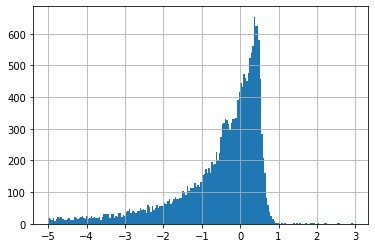

In [19]:
merged_set['landvar %'][merged_set['landvar %']>-5].hist(bins=200)

In [20]:
#seperate variables into categories and continuous
cats = ['propertyzoningdesc', 'buildingclasstypeid', 'heatingorsystemtypeid']
cont = ['lotsizesquarefeet', 'landtaxvaluedollarcnt', 'landtaxvaluedollarcnt','estimatesland', 'hashottuborspa_True', 'basementsqft', 
 'bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12', 'garagetotalsqft', 'poolcnt', 'unitcnt', 'yearbuilt', 'buildingqualitytypeid']

#seperate data set by standard deviation of error
v = 'landvar %'

large_variances_underestimates = merged_set.loc[merged_set[v]>=.6]
small_variances = merged_set.loc[(merged_set[v]<.6) & (merged_set[v]>-2)]
large_variances_overestimates = merged_set.loc[merged_set[v]<=-2]

#make a table
x1 = {i:'mean' for i in cont}
x2 = {i:[lambda x:x.value_counts().index[:1][0]] for i in cats} #mode categorical value
table_continuous_land_over = pd.concat([large_variances_overestimates.agg(x1).round(2), small_variances.agg(x1).round(2)], axis=1) #apply agg functions
table_categories_land_over = pd.concat([large_variances_overestimates.agg(x2).round(2), small_variances.agg(x2).round(2)], axis=0).transpose() #apply agg functions

table_continuous_land_under = pd.concat([large_variances_underestimates.agg(x1).round(2), small_variances.agg(x1).round(2)], axis=1) #apply agg functions
table_categories_land_under = pd.concat([large_variances_underestimates.agg(x2).round(2), small_variances.agg(x2).round(2)], axis=0).transpose() #apply agg functions

names = {0:'large_variances',1:'small_variances'}

#overestimates
table_continuous_land_over.rename(columns = names, inplace=True)
table_categories_land_over.columns = ['large_variances', 'small_variances']
table_continuous_land_over['variance'] = table_continuous_land_over['large_variances']-table_continuous_land_over['small_variances']
table_continuous_land_over['variance %'] = table_continuous_land_over['variance']/table_continuous_land_over['small_variances']
table_categories_land_over['variance'] = table_categories_land_over['large_variances']-table_categories_land_over['small_variances']

#underestimates
table_continuous_land_under.rename(columns = names, inplace=True)
table_categories_land_under.columns = ['large_variances', 'small_variances']
table_continuous_land_under['variance'] = table_continuous_land_under['large_variances']-table_continuous_land_under['small_variances']
table_continuous_land_under['variance %'] = table_continuous_land_under['variance']/table_continuous_land_under['small_variances']
table_categories_land_under['variance'] = table_categories_land_under['large_variances']-table_categories_land_under['small_variances']

### Overestimates - Land

When the algorithm overestimates the price of land it's there a generally smaller basements

In [21]:
format_dict = {'large_variances':'{0:,.2f}', 'small_variances': '{0:,.2f}', 'variance': '{0:,.2f}', 'variance %': '{:.2%}'}
table_continuous_land_over.style.format(format_dict)

,large_variances,small_variances,variance,variance %
lotsizesquarefeet,"21,421.24","22,767.80","-1,346.56",-5.91%
landtaxvaluedollarcnt,"48,924.32","289,040.41","-240,116.09",-83.07%
estimatesland,"233,121.75","273,365.16","-40,243.41",-14.72%
hashottuborspa_True,0.01,0.02,-0.01,-50.00%
basementsqft,482.50,903.00,-420.50,-46.57%
bathroomcnt,2.27,2.29,-0.02,-0.87%
bedroomcnt,3.25,3.22,0.03,0.93%
finishedsquarefeet12,"1,809.10","1,809.00",0.10,0.01%
garagetotalsqft,452.16,463.28,-11.12,-2.40%
poolcnt,1.00,1.00,0.00,0.00%


In [22]:
table_categories_land_over

,large_variances,small_variances,variance
propertyzoningdesc,42.00,42.00,0.00
buildingclasstypeid,4.00,4.00,0.00
heatingorsystemtypeid,2.00,2.00,0.00


### Underestimates - Land 

In these errors the lot sizes are noticeably larger, basements smaller, homes overall are smaller, and have older homes.

In [23]:
format_dict = {'large_variances':'{0:,.2f}', 'small_variances': '{0:,.2f}', 'variance': '{0:,.2f}', 'variance %': '{:.2%}'}
table_continuous_land_under.style.format(format_dict)

,large_variances,small_variances,variance,variance %
lotsizesquarefeet,"30,404.90","22,767.80","7,637.10",33.54%
landtaxvaluedollarcnt,"740,782.95","289,040.41","451,742.54",156.29%
estimatesland,"224,192.23","273,365.16","-49,172.93",-17.99%
hashottuborspa_True,0.02,0.02,0.00,0.00%
basementsqft,240.00,903.00,-663.00,-73.42%
bathroomcnt,1.96,2.29,-0.33,-14.41%
bedroomcnt,2.76,3.22,-0.46,-14.29%
finishedsquarefeet12,"1,559.44","1,809.00",-249.56,-13.80%
garagetotalsqft,427.96,463.28,-35.32,-7.62%
poolcnt,1.00,1.00,0.00,0.00%


In [24]:
table_categories_land_under

,large_variances,small_variances,variance
propertyzoningdesc,42.00,42.00,0.00
buildingclasstypeid,4.00,4.00,0.00
heatingorsystemtypeid,2.00,2.00,0.00


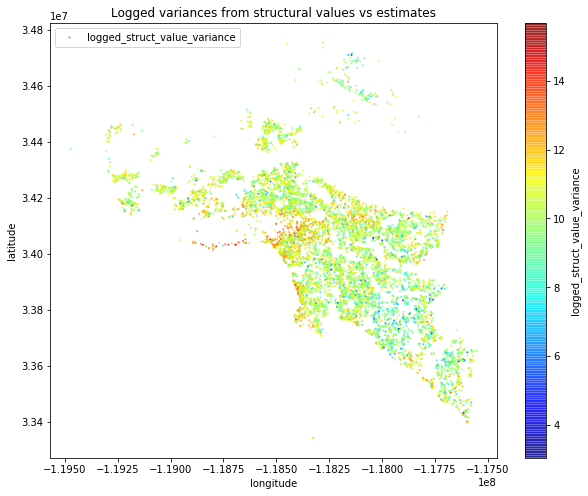

In [25]:
merged_set['logged_struct_value_variance'] = np.log(merged_set.structvar)

merged_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
    label="logged_struct_value_variance", s=1, figsize=(10,8),
    c="logged_struct_value_variance", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.title('Logged variances from structural values vs estimates')
plt.savefig('logged_structure_variances_mapped.png')

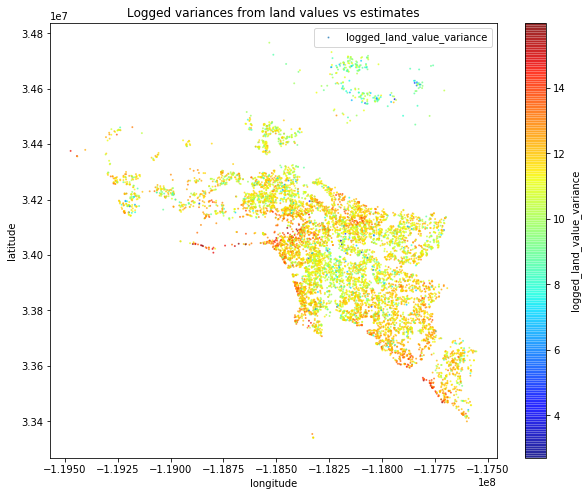

In [26]:
merged_set['logged_land_value_variance'] = np.log(merged_set.landvar)

merged_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
    label="logged_land_value_variance", s=1, figsize=(10,8),
    c="logged_land_value_variance", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Logged variances from land values vs estimates')
plt.legend()
plt.savefig('logged_land_variances_mapped.png')